In [166]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.teams import Team
from sportsreference.ncaab.roster import Player
from tqdm import tqdm
from sportsreference.ncaab.boxscore import Boxscore
from sklearn.linear_model import LogisticRegression,LinearRegression
import xgboost as xgb
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
import shap

In [147]:
df = pd.read_csv("ml_df_l3.csv")
df = df.drop(columns = [df.columns[i] for i in [0,71,72,74,75,78,79,7,8,17,42,43,62,73]],axis = 1)
df.columns.tolist()

['assist_percentage',
 'block_percentage',
 'effective_field_goal_percentage',
 'field_goal_percentage',
 'free_throw_attempt_rate',
 'free_throw_percentage',
 'offensive_rating',
 'offensive_rebound_percentage',
 'allowed_assist_percentage',
 'allowed_block_percentage',
 'allowed_effective_field_goal_percentage',
 'allowed_field_goal_percentage',
 'allowed_free_throw_attempt_rate',
 'allowed_free_throw_percentage',
 'allowed_offensive_rebound_percentage',
 'allowed_steal_percentage',
 'allowed_three_point_attempt_rate',
 'allowed_three_point_field_goal_percentage',
 'allowed_two_point_field_goal_percentage',
 'allowed_total_rebound_percentage',
 'allowed_true_shooting_percentage',
 'allowed_turnover_percentage',
 'pace',
 'simple_rating_system',
 'steal_percentage',
 'three_point_attempt_rate',
 'three_point_field_goal_percentage',
 'two_point_field_goal_percentage',
 'total_rebound_percentage',
 'true_shooting_percentage',
 'turnover_percentage',
 'win_percentage',
 'opp_assist_perce

In [148]:
for i in df.loc[:,df.columns[df.columns.str.contains('percent')]].columns:
    if df[i].max() > 1:
        df[i] = [j/100 for j in df[i]]

X = df.drop('result',1)
y = df.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [149]:
clf = RandomForestClassifier(n_estimators = 300,n_jobs = -1,max_depth = 5)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

0.7568214804063861
0.7489387177533471


In [150]:
imp_dict = {key:[] for key in ('feature','importance')}
for feat,imp in zip(X_train.columns,clf.feature_importances_):
    imp_dict['feature'].append(feat)
    imp_dict['importance'].append(imp)
    
imp_df = pd.DataFrame.from_dict(imp_dict)
imp_feats = imp_df.sort_values('importance',ascending = False).head(40)['feature'].tolist()

df2 = df.loc[:,df.columns[df.columns.isin(imp_feats)]]
X = df2
y = df.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [151]:
corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
for tup in high_corr_var:
    print('Removing {} as it is highly correllated with {}'.format(tup[1],tup[0]))

to_drop = []
for x,y in high_corr_var:
  if y not in to_drop:
    to_drop.append(y)

df2 = df2.drop([i for i in to_drop],axis = 1)

corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
assert high_corr_var == []
X = df2
y = df.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)
X_train

Removing field_goal_percentage as it is highly correllated with effective_field_goal_percentage
Removing true_shooting_percentage as it is highly correllated with effective_field_goal_percentage
Removing true_shooting_percentage as it is highly correllated with field_goal_percentage
Removing allowed_field_goal_percentage as it is highly correllated with allowed_effective_field_goal_percentage
Removing allowed_true_shooting_percentage as it is highly correllated with allowed_effective_field_goal_percentage
Removing allowed_two_point_field_goal_percentage as it is highly correllated with allowed_field_goal_percentage
Removing allowed_true_shooting_percentage as it is highly correllated with allowed_field_goal_percentage
Removing opp_field_goal_percentage as it is highly correllated with opp_effective_field_goal_percentage
Removing opp_true_shooting_percentage as it is highly correllated with opp_effective_field_goal_percentage
Removing opp_true_shooting_percentage as it is highly correll

,block_percentage,effective_field_goal_percentage,offensive_rating,offensive_rebound_percentage,allowed_assist_percentage,allowed_effective_field_goal_percentage,allowed_steal_percentage,allowed_three_point_field_goal_percentage,allowed_total_rebound_percentage,simple_rating_system,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,turnover_percentage,win_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_offensive_rating,opp_simple_rating_system,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_turnover_percentage,opp_win_percentage,opp_assist_percentage_allowed,opp_effective_field_goal_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,home
11884,0.117,0.515,111.5,0.314,0.558,0.496,0.077,0.320,0.507,6.55,0.373,0.488,0.493,0.142,0.710,0.092,0.544,110.7,1.90,0.386,0.523,0.511,0.150,0.657,0.448,0.496,0.084,0.363,0.489,1
14220,0.116,0.503,102.8,0.315,0.431,0.489,0.093,0.333,0.480,9.45,0.340,0.499,0.520,0.168,0.529,0.066,0.490,102.6,8.32,0.336,0.481,0.505,0.147,0.531,0.478,0.509,0.078,0.329,0.495,1
59302,0.084,0.547,106.6,0.250,0.507,0.512,0.089,0.334,0.498,0.17,0.354,0.561,0.502,0.161,0.543,0.085,0.556,110.0,6.79,0.352,0.580,0.478,0.147,0.781,0.548,0.501,0.090,0.309,0.522,0
56547,0.052,0.502,102.5,0.215,0.541,0.536,0.071,0.386,0.540,4.39,0.363,0.475,0.460,0.135,0.441,0.139,0.555,112.1,16.71,0.361,0.562,0.519,0.166,0.750,0.468,0.463,0.090,0.320,0.481,0
20081,0.120,0.453,93.2,0.343,0.573,0.516,0.115,0.341,0.479,-12.38,0.275,0.470,0.521,0.179,0.273,0.054,0.537,108.4,-1.23,0.357,0.539,0.470,0.143,0.560,0.455,0.529,0.079,0.330,0.530,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64279,0.124,0.546,106.1,0.242,0.485,0.526,0.096,0.374,0.501,-4.78,0.346,0.566,0.499,0.160,0.452,0.117,0.462,103.3,7.97,0.315,0.454,0.484,0.119,0.424,0.491,0.490,0.074,0.331,0.516,0
3956,0.143,0.506,106.9,0.290,0.499,0.470,0.089,0.338,0.531,5.75,0.328,0.514,0.469,0.137,0.750,0.112,0.489,94.2,-15.84,0.313,0.500,0.490,0.213,0.345,0.486,0.494,0.122,0.355,0.510,1
43833,0.100,0.470,99.3,0.314,0.491,0.463,0.088,0.288,0.485,8.51,0.297,0.487,0.515,0.180,0.484,0.106,0.465,100.9,18.51,0.286,0.479,0.556,0.170,0.677,0.476,0.445,0.105,0.288,0.444,0
46178,0.107,0.436,91.3,0.305,0.564,0.498,0.099,0.337,0.510,0.23,0.295,0.433,0.490,0.171,0.313,0.110,0.480,100.1,7.77,0.334,0.468,0.497,0.158,0.529,0.525,0.453,0.084,0.326,0.503,1


In [152]:
clf = LogisticRegression(max_iter = 10000)
clf.fit(X_train,y_train)
score1 = accuracy_score(y_train,clf.predict(X_train))
score2 = accuracy_score(y_test,clf.predict(X_test))
print(score1,score2)

0.7720791001451379 0.7655926853162077


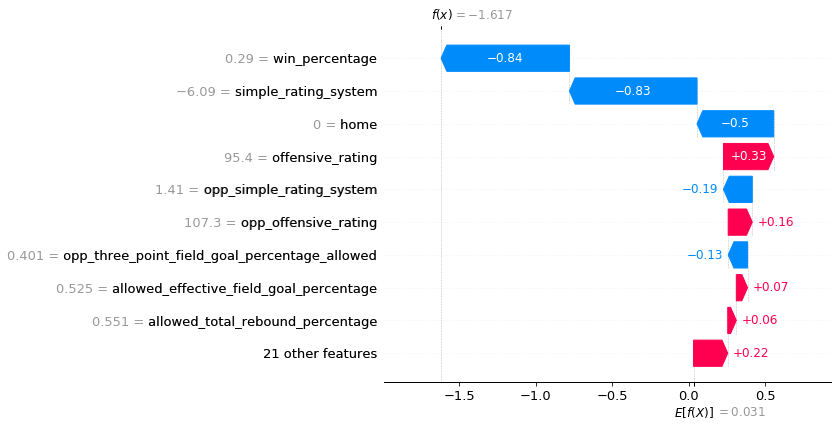

In [116]:
import shap
explainer = shap.Explainer(clf,X_train)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[7])

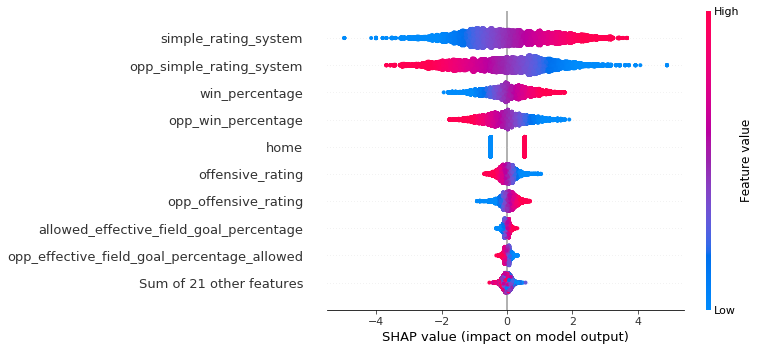

In [117]:
shap.plots.beeswarm(shap_values)

In [15]:
df_agg = pd.DataFrame()
for t in Teams(2022):
    try:
        temp_df = t.dataframe
        df_agg = pd.concat([df_agg,temp_df],axis=0)
    except:
        pass
        
in_agg = ['Southern Methodist','Brigham Young','University of California','Illinois-Chicago','Connecticut','Massachusetts','Nevada-Las Vegas','North Carolina',
         'North Carolina-Wilmington','North Carolina State','Pittsburgh','Louisiana State','Texas Christian','Southern California','Virginia Commonwealth']
to_change = ['SMU','BYU','California','UIC','UConn','UMass','UNLV','UNC','UNC Wilmington','NC State','Pitt','LSU','TCU','USC','VCU']
rename_dict = dict(zip(in_agg,to_change))
df_agg['name'] = df_agg.name.replace(rename_dict)
df_agg

,abbreviation,assist_percentage,assists,away_losses,away_wins,block_percentage,blocks,conference,conference_losses,conference_wins,defensive_rebounds,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,free_throws_per_field_goal_attempt,games_played,home_losses,home_wins,losses,minutes_played,name,net_rating,offensive_rating,offensive_rebound_percentage,offensive_rebounds,opp_assist_percentage,opp_assists,opp_block_percentage,opp_blocks,opp_defensive_rebounds,opp_effective_field_goal_percentage,opp_field_goal_attempts,opp_field_goal_percentage,opp_field_goals,opp_free_throw_attempt_rate,opp_free_throw_attempts,opp_free_throw_percentage,opp_free_throws,opp_free_throws_per_field_goal_attempt,opp_offensive_rating,opp_offensive_rebound_percentage,opp_offensive_rebounds,opp_personal_fouls,opp_points,opp_steal_percentage,opp_steals,opp_three_point_attempt_rate,opp_three_point_field_goal_attempts,opp_three_point_field_goal_percentage,opp_three_point_field_goals,opp_two_point_field_goal_attempts,opp_two_point_field_goal_percentage,opp_two_point_field_goals,opp_total_rebound_percentage,opp_total_rebounds,opp_true_shooting_percentage,opp_turnover_percentage,opp_turnovers,pace,personal_fouls,points,simple_rating_system,steal_percentage,steals,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_attempts,three_point_field_goal_percentage,three_point_field_goals,two_point_field_goal_attempts,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnover_percentage,turnovers,win_percentage,wins
ABILENE-CHRISTIAN,ABILENE-CHRISTIAN,55.9,170,2,1,6.5,20,wac,0,0,249,0.521,654,0.465,304,0.362,237,0.722,171,0.261,10,0,7,2,415,Abilene Christian,None,109.9,31.2,118,48.5,95,6.9,30,260,0.442,508,0.386,196,0.439,223,0.717,160,0.315,None,24.8,82,217,609,8.4,65,0.394,200,0.285,57,308,0.451,139,48.2,342,0.496,28.1,240,74.8,220,853,7.38,16.1,125,-1.62,0.338,221,0.335,74,433,0.531,230,51.8,367,0.556,14.6,131,0.800,8
AIR-FORCE,AIR-FORCE,56.1,128,2,1,10.9,38,mwc,0,0,232,0.542,493,0.462,228,0.243,120,0.658,79,0.160,10,0,4,3,400,Air Force,None,95.0,19.3,54,43.8,92,8.3,23,226,0.457,512,0.410,210,0.338,173,0.746,129,0.252,None,29.3,96,160,597,9.5,61,0.316,162,0.296,48,350,0.463,162,53.0,322,0.502,19.5,144,64.5,172,613,-8.11,11.2,72,-9.71,0.438,216,0.361,78,277,0.542,150,47.0,286,0.557,21.7,152,0.700,7
AKRON,AKRON,48.4,122,1,1,8.5,32,mac,0,0,274,0.533,551,0.457,252,0.407,224,0.638,143,0.260,10,0,5,3,400,Akron,None,109.0,33.2,112,35.9,78,6.3,20,225,0.441,556,0.390,217,0.268,149,0.691,103,0.185,None,23.7,85,200,593,9.1,61,0.326,181,0.309,56,375,0.429,161,44.5,310,0.473,17.0,128,67.0,169,730,0.11,9.6,64,-2.39,0.425,234,0.355,83,317,0.533,169,55.5,386,0.555,15.9,124,0.700,7
ALABAMA-AM,ALABAMA-AM,45.3,86,8,0,7.4,21,swac,0,0,210,0.383,547,0.347,190,0.203,111,0.667,74,0.135,9,0,1,8,360,Alabama A&M,None,78.6,25.4,95,67.6,152,7.5,30,279,0.508,526,0.428,225,0.297,156,0.724,113,0.215,None,34.8,112,130,647,10.4,65,0.460,242,0.347,84,284,0.496,141,56.2,391,0.539,18.5,136,69.7,153,493,-17.75,12.0,75,-0.64,0.269,147,0.265,39,400,0.378,151,43.8,305,0.411,17.4,126,0.111,1
ALABAMA-BIRMINGHAM,ALABAMA-BIRMINGHAM,45.0,167,1,1,13.0,56,cusa,0,0,303,0.519,802,0.463,371,0.252,202,0.678,137,0.171,12,1,7,3,480,Alabama-Birmingham,None,109.9,32.6,156,47.5,122,8.4,45,322,0.453,653,0.394,257,0.315,206,0.699,144,0.221,None,27.2,113,187,735,7.3,64,0.340,222,0.347,77,431,0.418,180,48.7,435,0.489,24.8,247,73.5,208,969,12.65,17.1,151,0.35,0.329,264,0.341,90,538,0.522,281,51.3,459,0.540,13.2,137,0.750,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [155]:
team_1 = 'Purdue'
team_2 = 'Louisville'
home_team = team_1
away_team = team_2
if team_1 in df_agg.name.unique().tolist():
    if team_2 in df_agg.name.unique().tolist():
        temp_df_2 = df_agg.loc[df_agg.name == team_1].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        temp_df_3 = df_agg.loc[df_agg.name == team_2].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        old_names = temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()
        new_names = [i.replace('opp','allowed') for i in temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()]
        name_dict = dict(zip(old_names,new_names))
        temp_df_2_dict = temp_df_2.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_2_dict.update(temp_df_3.iloc[0,:10].rename(dict(zip(temp_df_3.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_3.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,25:].rename(dict(zip(temp_df_3.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_3.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,10:25].rename(dict(zip(temp_df_3.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_3.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict = temp_df_3.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_3_dict.update(temp_df_2.iloc[0,:10].rename(dict(zip(temp_df_2.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_2.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,25:].rename(dict(zip(temp_df_2.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_2.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,10:25].rename(dict(zip(temp_df_2.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_2.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        for i in temp_df_3_dict.keys():
            temp_df_2_dict[i]+=(temp_df_3_dict[i])
        master_dict = {key:[] for key in temp_df_2_dict.keys()}

        for i in temp_df_2_dict.keys():
            master_dict[i] += temp_df_2_dict[i]
        df_pred = pd.DataFrame.from_dict(master_dict)
        df_pred = df_pred[df_pred.name == home_team]
        df_pred['home'] = 1
        df_pred = df_pred[[i for i in df_pred.columns if i in X_train.columns]]
        
        for i in df_pred.loc[:,df_pred.columns[df_pred.columns.str.contains('percent')]].columns:
             if df_pred[i].max() > 1:
                df_pred[i] = [j/100 for j in df_pred[i]]
                 
    else:
        print("Away Team Not Formatted Correctly")
        df_pred = None
else:
    print("Home Team Not Formatted Correctly")
    df_pred = None
if df_pred is not None:
    display(df_pred)

loss_prob = clf.predict_proba(df_pred)[0][0]
win_prob = clf.predict_proba(df_pred)[0][1]

if win_prob >= loss_prob:
    print(home_team + ' has a ' + str(round(win_prob*100,2)) + '% chance of winning at home against ' +away_team)
else:
    print(away_team + ' has a ' + str(round(loss_prob*100,2)) + '% chance of winning on the road against ' + home_team)

,block_percentage,effective_field_goal_percentage,offensive_rating,offensive_rebound_percentage,allowed_assist_percentage,allowed_effective_field_goal_percentage,allowed_steal_percentage,allowed_three_point_field_goal_percentage,allowed_total_rebound_percentage,simple_rating_system,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,turnover_percentage,win_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_offensive_rating,opp_simple_rating_system,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_turnover_percentage,opp_win_percentage,opp_assist_percentage_allowed,opp_effective_field_goal_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,home
0,0.123,0.595,124.8,0.396,0.525,0.462,0.079,0.31,0.392,23.43,0.404,0.586,0.608,0.153,0.917,0.075,0.485,98.4,8.83,0.305,0.505,0.531,0.171,0.636,0.496,0.446,0.101,0.302,0.469,1


Purdue has a 91.48% chance of winning at home against Louisville


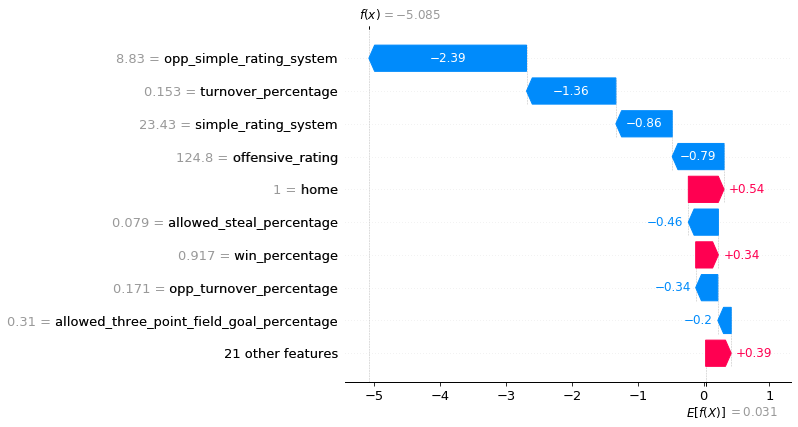

In [157]:
shap_values = explainer(df_pred)
shap.plots.waterfall(shap_values[0])

# Predicting Scores

## Points For

In [184]:
df_points = pd.read_csv('ml_df_l3.csv')
df_points = df_points.drop(columns = [df_points.columns[i] for i in [0,71,72,74,75,77,7,8,17,42,43,62,73,79]],axis = 1)
X = df_points.drop('points_for',axis = 1)
y = df_points.points_for
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.sample(5)

,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,offensive_rating,offensive_rebound_percentage,allowed_assist_percentage,allowed_block_percentage,allowed_effective_field_goal_percentage,allowed_field_goal_percentage,allowed_free_throw_attempt_rate,allowed_free_throw_percentage,allowed_offensive_rebound_percentage,allowed_steal_percentage,allowed_three_point_attempt_rate,allowed_three_point_field_goal_percentage,allowed_two_point_field_goal_percentage,allowed_total_rebound_percentage,allowed_true_shooting_percentage,allowed_turnover_percentage,pace,simple_rating_system,steal_percentage,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage,opp_assist_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_field_goal_percentage,opp_free_throw_attempt_rate,opp_free_throw_percentage,opp_offensive_rating,opp_offensive_rebound_percentage,opp_pace,opp_simple_rating_system,opp_steal_percentage,opp_three_point_attempt_rate,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_true_shooting_percentage,opp_turnover_percentage,opp_win_percentage,opp_assist_percentage_allowed,opp_block_percentage_allowed,opp_effective_field_goal_percentage_allowed,opp_field_goal_percentage_allowed,opp_free_throw_attempt_rate_allowed,opp_free_throw_percentage_allowed,opp_offensive_rebound_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_attempt_rate_allowed,opp_three_point_field_goal_percentage_allowed,opp_two_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,opp_true_shooting_percentage_allowed,opp_turnover_percentage_allowed,home
31476,57.2,10.3,0.521,0.467,0.387,0.708,106.8,31.8,49.9,9.2,0.496,0.432,0.382,0.731,28.7,9.1,0.367,0.348,0.481,47.9,0.538,16.3,67.4,7.31,9.7,0.328,0.329,0.533,52.1,0.555,16.8,0.500,56.2,6.2,0.541,0.446,0.247,0.736,104.7,24.6,69.4,0.67,7.6,0.504,0.377,0.517,47.1,0.566,17.3,0.387,51.4,10.3,0.535,0.465,0.285,0.706,31.2,8.7,0.400,0.349,0.542,52.9,0.560,14.1,1
7055,50.3,6.0,0.535,0.466,0.372,0.709,110.7,31.2,51.8,7.5,0.527,0.449,0.409,0.685,26.4,7.3,0.442,0.353,0.526,47.1,0.559,13.8,68.2,-5.75,6.7,0.331,0.413,0.493,52.9,0.566,15.1,0.433,48.7,8.4,0.527,0.460,0.299,0.657,107.5,29.6,65.1,-6.85,8.8,0.383,0.349,0.529,50.1,0.547,15.3,0.433,49.7,9.8,0.493,0.431,0.450,0.720,29.3,8.4,0.365,0.340,0.483,49.9,0.539,14.4,0
62626,50.3,11.2,0.519,0.442,0.305,0.722,104.5,22.2,44.4,7.3,0.520,0.458,0.324,0.718,31.5,8.4,0.353,0.355,0.514,55.2,0.552,18.0,76.3,-0.64,11.7,0.447,0.342,0.523,44.8,0.549,14.3,0.622,48.3,9.7,0.481,0.418,0.338,0.678,97.1,26.4,69.5,-14.57,6.8,0.412,0.308,0.494,47.4,0.513,16.8,0.290,54.6,9.5,0.513,0.445,0.335,0.720,30.8,8.9,0.389,0.352,0.503,52.6,0.547,15.8,1
5655,58.1,6.0,0.528,0.456,0.345,0.768,100.2,23.4,51.5,10.0,0.547,0.477,0.306,0.700,31.4,10.9,0.363,0.388,0.527,52.9,0.571,14.7,58.9,-6.04,7.5,0.351,0.408,0.482,47.1,0.567,20.1,0.290,58.1,9.7,0.543,0.476,0.365,0.696,111.4,28.3,69.8,17.94,9.2,0.368,0.362,0.543,50.5,0.571,13.9,0.735,55.7,9.1,0.476,0.416,0.240,0.733,29.6,8.1,0.344,0.347,0.452,49.5,0.506,16.0,1
51409,47.8,6.9,0.498,0.436,0.369,0.712,97.9,23.1,47.9,10.6,0.561,0.494,0.428,0.714,30.3,8.6,0.329,0.413,0.533,54.1,0.594,15.4,68.9,-17.36,7.8,0.339,0.364,0.473,45.9,0.535,16.7,0.200,53.2,5.4,0.463,0.400,0.354,0.704,94.5,22.8,71.0,-18.29,8.5,0.372,0.338,0.436,45.8,0.503,16.0,0.167,52.9,9.3,0.551,0.477,0.336,0.726,29.1,8.6,0.382,0.387,0.532,54.2,0.580,15.2,1


In [ ]:
pf_reg = RandomForestRegressor(n_jobs = -1, max_depth= 6,n_estimators = 200)
pf_reg.fit(X_train,y_train)
print('Training:',pf_reg.score(X_train,y_train),mean_squared_error(y_train,pf_reg.predict(X_train),squared = False))
print('Testing:',pf_reg.score(X_test,y_test),mean_squared_error(y_test,pf_reg.predict(X_test),squared = False))

In [180]:
imp_dict = {key:[] for key in ('feature','importance')}
for feat,imp in zip(X_train.columns,pf_reg.feature_importances_):
    imp_dict['feature'].append(feat)
    imp_dict['importance'].append(imp)
    
imp_df = pd.DataFrame.from_dict(imp_dict)
imp_feats = imp_df.sort_values('importance',ascending = False).head(40)['feature'].tolist()
imp_df.sort_values('importance',ascending = False)

,feature,importance
6,offensive_rating,0.326328
64,points_against,0.174795
40,opp_pace,0.165931
52,opp_effective_field_goal_percentage_allowed,0.095618
41,opp_simple_rating_system,0.089719
...,...,...
39,opp_offensive_rebound_percentage,0.000003
37,opp_free_throw_percentage,0.000002
16,allowed_three_point_attempt_rate,0.000001
51,opp_block_percentage_allowed,0.000000
